In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2

tf.__version__

'2.5.0'

In [ ]:
!git clone https://github.com/CartagenaMinas/Melanomas.git

fatal: destination path 'Melanomas' already exists and is not an empty directory.


In [ ]:
import os
os.listdir("Melanomas")

['Keras_baseline.ipynb', 'data', 'exploracion.ipynb', '.git']

In [ ]:
PATH="Melanomas/data"
os.listdir(PATH)

['jpeg224',
 'test.csv',
 'sample_submission.csv',
 'train.csv',
 'train_split.csv',
 'val_split.csv',
 'subset.csv']

In [ ]:
import pandas as pd
train=pd.read_csv(f"{PATH}/subset.csv")
val=pd.read_csv(f"{PATH}/val_split.csv")
train.shape,val.shape

((2220, 8), (10932, 8))

In [ ]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_0533349,IP_5208504,female,45.0,lower extremity,unknown,benign,0
1,ISIC_8814612,IP_0414408,male,50.0,torso,unknown,benign,0
2,ISIC_6515241,IP_6245507,male,45.0,lower extremity,unknown,benign,0
3,ISIC_5075261,IP_2117218,male,40.0,upper extremity,unknown,benign,0
4,ISIC_2624460,IP_1969685,male,50.0,torso,unknown,benign,0


In [ ]:
BATCH_SIZE=64
AUTO=tf.data.experimental.AUTOTUNE

def decode(name,label):
  img=tf.io.read_file(name)#lo lee en byts
  img=tf.image.decode_jpeg(img,channels=3)#lo carga como imagen
  img=tf.cast(img,tf.float32)#/255#cambia la presicion
  return img,label


def augment(img,label):
  #augmentation
  img=tf.image.random_flip_left_right(img)
  img=tf.image.random_flip_up_down(img)
  return img, label


def load_ds(df):
  options=tf.data.Options()
  options.experimental_deterministic=False#Para que lo cargue en orden aleatorio
  imgs, labels=df["image_name"].values,df["target"].values#Creo una lista 
  imgs=[f"{PATH}/jpeg224/train/{name}.jpg" for name in imgs]#Creo una lista con mis rutas
  ds=tf.data.Dataset.from_tensor_slices((imgs,labels))
  ds=ds.with_options(options)
  ds=ds.map(decode,num_parallel_calls=AUTO)#uso todos los procesadores
  #ds=ds.cache()#Guarda la imagen en memoria, lo puedo usar si tengo mucha ram
  ds=ds.map(augment,num_parallel_calls=AUTO)
  ds=ds.shuffle(2048)
  ds=ds.batch(BATCH_SIZE)
  ds=ds.prefetch(buffer_size=AUTO) #Mientras la gpu calcula la cpu carga imagenes
  return ds



In [ ]:
train_ds=load_ds(train)
val_ds=load_ds(val)

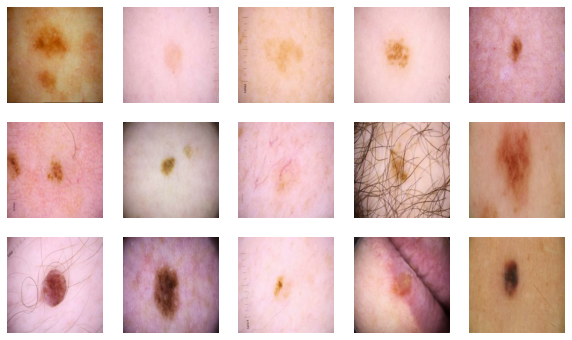

In [ ]:
import matplotlib.pyplot as plt
import random
r,c=3,5
fig=plt.figure(figsize=(2*c,2*r))
for _r in range (r):
  for _c in range (c):
    plt.subplot(r,c,_r*c+_c+1)
    for imgs, labels in train_ds.take(1):
      img=imgs[0].numpy()/255
      plt.imshow(img)
      plt.axis(False)
plt.show()

In [ ]:
IMAGE_SIZE= (224,224,3)

encoder=ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights="imagenet"
)
encoder.trainable=False #No aplicar los gradientes calculados

inputs=keras.Input(shape=IMAGE_SIZE)
x = keras.layers.experimental.preprocessing.RandomFlip()(inputs)
x=keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
x=encoder(x,training=False)#No calcula los gradientes
x=keras.layers.GlobalAveragePooling2D()(x)
outputs=keras.layers.Dense(1,activation="sigmoid")(x)
model=keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name="auc")]
)

In [ ]:
filepath="./checkpoints/checkpoint"
cb=tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_auc",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max"
)

In [ ]:
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_steps=10,
    callbacks=[cb])

Epoch 1/10
35/35 [==============================] - 28s 374ms/step - loss: 0.3611 - auc: 0.4176 - val_loss: 0.1626 - val_auc: 0.3351

Epoch 00001: val_auc improved from -inf to 0.33515, saving model to ./checkpoints/checkpoint
Epoch 2/10
35/35 [==============================] - 10s 279ms/step - loss: 0.1190 - auc: 0.3897 - val_loss: 0.1864 - val_auc: 0.2962

Epoch 00002: val_auc did not improve from 0.33515
Epoch 3/10
35/35 [==============================] - 10s 284ms/step - loss: 0.1067 - auc: 0.4487 - val_loss: 0.1065 - val_auc: 0.2106

Epoch 00003: val_auc did not improve from 0.33515
Epoch 4/10
35/35 [==============================] - 10s 287ms/step - loss: 0.0951 - auc: 0.5100 - val_loss: 0.1058 - val_auc: 0.3973

Epoch 00004: val_auc improved from 0.33515 to 0.39729, saving model to ./checkpoints/checkpoint
Epoch 5/10
35/35 [==============================] - 10s 286ms/step - loss: 0.0869 - auc: 0.6587 - val_loss: 0.0861 - val_auc: 0.6160

Epoch 00005: val_auc improved from 0.3972

In [ ]:
#Cargar los Pesos
model.load_weights(filepath)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.evaluate(val_ds)

171/171 [==============================] - 34s 188ms/step - loss: 0.0786 - auc: 0.7736


[0.07861638069152832, 0.7736003994941711]

In [ ]:
test=pd.read_csv(f"{PATH}/test.csv")
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [ ]:
BATCH_SIZE=256

def decode_test(name):
  img=tf.io.read_file(name)#lo lee en byts
  img=tf.image.decode_jpeg(img,channels=3)#lo carga como imagen
  img=tf.cast(img,tf.float32)#/255#cambia la presicion
  return img

def load_test_ds(df):
  imgs=df["image_name"].values#Creo una lista 
  imgs=[f"{PATH}/jpeg224/test/{name}.jpg" for name in imgs]#Creo una lista con mis rutas
  ds=tf.data.Dataset.from_tensor_slices(imgs)
  ds=ds.map(decode_test)
  ds=ds.batch(BATCH_SIZE)
  return ds

In [ ]:
test_ds=load_test_ds(test)

In [ ]:
preds=model.predict(test_ds)

In [ ]:
preds

array([[0.00924932],
       [0.01072523],
       [0.01220261],
       ...,
       [0.02067835],
       [0.00714954],
       [0.2843888 ]], dtype=float32)

In [ ]:
submission=pd.DataFrame({
    "image_name":test["image_name"].values,"target":preds.ravel()
})
submission.head()

,image_name,target
0,ISIC_0052060,0.009249
1,ISIC_0052349,0.010725
2,ISIC_0058510,0.012203
3,ISIC_0073313,0.001309
4,ISIC_0073502,0.009677


In [ ]:
submission.to_csv("sumissionDA2.csv",index=False)